# Data Exploration

In [4]:
import pandas as pd

### Explore/ Preprocess the .csv

In [5]:
# load .csv and preview
df = pd.read_csv('./data/gicsd_labels.csv')
df.head()

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


In [13]:
def summarise(df):
    """Basic summary of dataframe shape, dtypes and columns"""
    print('--- data types ---')
    print(df.dtypes,'\n')
    print('--- shape ---')
    print(df.shape,'\n')
    print('--- columns ---')
    print(df.columns,'\n')

In [14]:
summarise(df)

--- data types ---
IMAGE_FILENAME    object
 LABEL            object
dtype: object 

--- shape ---
(800, 2) 

--- columns ---
Index(['IMAGE_FILENAME', ' LABEL'], dtype='object') 



In [15]:
# rm whitespace from col name
df = df.rename(columns={' LABEL': 'LABEL'})
# check one
df.LABEL[0]

' FULL_VISIBILITY '

In [16]:
# strip whitespace of all values in df
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [17]:
# Check for missing values
check_nulls_df = df.isnull()
print (check_nulls_df['LABEL'].value_counts(), '\n')
print (check_nulls_df['IMAGE_FILENAME'].value_counts())

False    800
Name: LABEL, dtype: int64 

False    800
Name: IMAGE_FILENAME, dtype: int64


In [18]:
# value counts of ' LABEL' column
df['LABEL'].value_counts()

FULL_VISIBILITY       646
PARTIAL_VISIBILITY    123
NO_VISIBILITY          31
Name: LABEL, dtype: int64

In [19]:
# check if 'IMAGE_FILENAME' col is unique
df['IMAGE_FILENAME'].is_unique

True

### Explore the folder with images 

In [20]:
def get_files(filepath, extension):
    import os, glob
    """get list of all files within a directory"""
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.{}'.format(extension)))
        for f in files :
            all_files.append(os.path.abspath(f))
    return all_files

def get_filenames(filepaths):
    import os
    """get list of filenames from a list of filepaths"""
    filenames = list()
    for path in filepaths:
        name = os.path.basename(path)
        filenames.append(name)
    return filenames

def check_lists_equal(list1, list2):
    """check if two unordered lists are equal; same elements, same length"""
    if set(list1) == set(list2):
        return True
    else:
        return False
    
def match_filename_to_filepath(filenames_list, paths_list):
    import os
    """returns list of ordered paths to corresponding to filenames list input"""
    ordered_paths = []
    for filename in filenames_list:
        for path in paths_list:
            subdir = os.path.dirname(path)
            name = os.path.basename(path)
            if filename == name:
                ordered_paths.append(
                    os.path.join(subdir,name))
    return ordered_paths

In [21]:
# generate list of filenames & preview
filenames_list = list(df.IMAGE_FILENAME)
filenames_list[0:3]

['GICSD_1_0_3.png', 'GICSD_1_0_13.png', 'GICSD_1_1_33.png']

In [1]:
# generate list of filepaths & preview
paths_list = get_files('./data/images/','png')

In [23]:
# check that df.IMAGE_FILENAME matches all image filenames in folder    
check_lists_equal(
    get_filenames(paths_list), 
    list(df['IMAGE_FILENAME'])
)

True

In [2]:
# get list of paths corresponding to df.IMAGE_FILENAME
ordered_paths = match_filename_to_filepath(filenames_list, paths_list)

In [3]:
# Add filepaths to df
df['FILEPATH'] = pd.Series(ordered_paths)

In [26]:
# check image size !!!!
from PIL import Image
def check_image_size(image_path):
    img = Image.open(image_path)
    width, height = img.size
    return width, height

def add_img_sizes(df, filepaths):
    img_width = list()
    img_height = list()
    for path in filepaths:
        width, height = check_image_size(path)
        img_width.append(width)
        img_height.append(height)
    df['WIDTH'] = pd.Series(img_width)
    df['HEIGHT'] = pd.Series(img_height)

In [4]:
add_img_sizes(df, ordered_paths)

In [28]:
print(df.WIDTH.value_counts())
print(df.HEIGHT.value_counts())

192    800
Name: WIDTH, dtype: int64
192    800
Name: HEIGHT, dtype: int64


In [5]:
# double check with pandas_profiling library
# import pandas_profiling
# df.profile_report(style={'full_width':True})

### Preliminary observations

* Total of 800 images available in the dataset
* All images have the same size of 192x192 pixels
* The image filenames are unique IDs matching to df.IMAGE_FILENAME
* df.LABEL values had whitespaces which were trimmed
* No missing values in .csv
* 646 out of 800 (0.801) images have ID cards with `FULL_VISIBILITY`
* 123 out of 800 (0.154) images have ID cards with `PARTIAL_VISIBILITY`
* 31 out of 800 (0.039) images have ID cards with `NO_VISIBILITY`

# Segmenting the Images

First split the images into 3 separate folders for each visibility classification; partial, no, full visibility.

In [80]:
def split_image_dataset(df, visibility, dst_path):
    from shutil import copyfile
    import os
    """create directory of images with different labelled visibilities 
    and copy corresponding images to folder"""
    # split df into category of visibility 
    df = df.loc[df['LABEL'] == visibility]
    
    if not os.path.exists(dst_path):
        #create new dst folder
        os.mkdir(dst_path)
        count = 0
        for index, row in df.iterrows():
            src = df.FILEPATH[index]
            out_filename = df.IMAGE_FILENAME[index]
            dst = '{}/{}'.format(dst_path, out_filename)
            copyfile(src, dst)
            count+=1
        print('Success! Copied {} files to {}'.format(count, dst_path))
    else:
        print('dst_path already exists! Skipping!')

In [ ]:
# Split into 3 df categories of Image visibilities
split_image_dataset(df, 'FULL_VISIBILITY', './data/split_images/full_visibility')
split_image_dataset(df, 'PARTIAL_VISIBILITY', './data/split_images/partial_visibility')
split_image_dataset(df, 'NO_VISIBILITY', './data/split_images/no_visibility')

## Split to train, validate, test

In [123]:
def split_train_val_test(in_dir, out_dir, split_ratio=(.70, .15, .15)):
    """
    args: 
        - in_dir: directory containing subdirectory of images, each subdirectory represents 
        a single label/ classification of images
        - out_dir: destination directory. A train, val and test folder will be created, 
        with each containing splits of each subdirectory classification
    """
    import split_folders
    split_folders.ratio(in_dir, output=out_dir, seed=1337, ratio=split_ratio)

In [124]:
split_train_val_test('./data/split_images/', './data/train_validate_test')

Copying files: 800 files [00:01, 621.43 files/s]


Number of images (train-validate-test):
1. `FULL_VISIBILITY` 452-97-97
    
2. `PARTIAL_VISIBILITY` 86-19-18
    
3. `NO_VISIBILITY` 21-5-5
    

# Data Augmentation

Increase ***training*** dataset for uneven classes `PARTIAL_VISIBILITY` and `NO_VISIBILITY`, by generating additional examples via simple geometric transformations -  since there are very little images for those two classes. Only transform images according to what would be realistic.

Random transformations for `PARTIAL_VISIBILITY` (5x per image):
* zooming 
* brightness
* rotation
* shearing (perspective)

Random transformations for `NO_VISIBILITY` (10x per image):
* zooming
* brightness 
* rotation
* horizontal/vertical flips
* shearing (perspective)
* translation (width shift)

In [75]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import os

def augment_image(generator, image_path, sample_size, dest_dir):
    """
    Generates multiple images from single image via certain geometric transformations.
    Saves new images to a directory with original filename as prefix.
    
    args:
        - generator: keras.preprocessing.image.ImageDataGenerator()
        - image_path: path to image file
        - sample_size: number of images to generate
        - dest_dir: directory to save the new images to
    """
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img_arr = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(img_arr, 0)
    # prepare iterator
    prefix = os.path.basename(image_path).split('.')[0]
    it = generator.flow(samples, 
                      batch_size=1,  
                      save_to_dir=dest_dir, 
                      save_prefix=prefix, 
                      save_format='png'
                     )
    # generate samples 
    for i in range(sample_size):
        # generate batch of images
        batch = it.next()

## NO_VISIBILITY training data augmentation

In [81]:
# set image data augmentation generator
no_visibility_generator = ImageDataGenerator(
    shear_range=0.3,
    horizontal_flip=True, # random
    vertical_flip=True, # random
    width_shift_range=0.2,
    rotation_range=180,
    brightness_range=[1.0,1.3],
    zoom_range=[0.7,1.0],
    fill_mode = 'reflect'
)

# get list of no_visibility files
no_visibility_training_files = get_files(
    './data/train_validate_test/train/no_visibility/', 
    'png')

# generate 10 x new images for no_visibility
for image_path in no_visibility_training_files:
    augment_image(
        no_visibility_generator, 
        image_path, 
        10, 
        './augment/train/no_visibility/'
    )

## PARTIAL_VISIBILITY training data augmentation

In [82]:
# set image data augmentation generator
partial_visibility_generator = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    brightness_range=[1.0,1.3],
    zoom_range=[0.8, 1],
    fill_mode = 'reflect'
)

#get list of partial_visibility files
partial_visibility_training_files = get_files(
    './data/train_validate_test/train/partial_visibility/', 
    'png')

# generate 5x x new images for partial_visibility
for image_path in partial_visibility_training_files:
    augment_image(
        partial_visibility_generator, 
        image_path, 
        5, 
        './augment/train/partial_visibility/'
    )

## Data Augmentation Summary

Increases in the training data:
- `PARTIAL_VISIBILITY` 
 * Original split; 86-19-18
 * After data augmentation; 430-19-18
- `NO_VISIBILITY` 
 * Original split; 21-5-5
 * After data augmentation; 210-5-5
 
TOTAL IMAGES: 1333

Ideally one should gather more data for those classes and augment data during training time, at every epoch, to increase generalizability of our model. So the network will not process the original images multiple times, but will process new images at each and every epoch. This should lead to a model that performs better on the validation/test data.

# Feature Engineering

Create a function that transforms an image (in the format of a numpy array) into a single-channel image. Explain the approach used to achieve this. 

In [86]:
import cv2
#convert RGB img to numpy.array
img = cv2.imread('./data/images/GICSD_1_0_3.png')
print ("RGB shape:", img.shape, "\n")
# print(img[0:1], '\n')

#convert to 1x channel image (greyscale)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Grayscale shape:",img_gray.shape)
# print(img_gray[0:1])

RGB shape: (192, 192, 3) 

Grayscale shape: (192, 192)


Each parameter (red, green, and blue) defines the intensity of the color as an int between 0 to 255.

* (255,0,0) == red
* (0,255,0) == green
* (0,0,255) == blue

All colors are made up of specific ratios of R:G:B. 

Each pixel in the image is converted to it's specific RGB color tuple in the np.array thus shape is 192 x 192 x 3

Some methods of RGB conversion to Grayscale:
- Simple; grayscale = R + G + B / 3
- Luminance; grayscale = (0.2125 * color.r) + (0.7154 * color.g) + (0.0721 * color.b) **method used by us below

## Convert images to Grayscale

In [169]:
import cv2
def image_to_gray(infile_path): 
    #convert RGB img to numpy.array
    img = cv2.imread(infile_path) #'./data/images/GICSD_1_0_3.png'
    # as cv2 is BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #convert to 1x channel image (greyscale)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def directory_to_gray(in_dir, out_dir):
    """
    Converts all images in a given directory to 1x channel image.
    Save grayscale images to another directory.
    """
    import cv2, os
    # list files
    filepaths = get_files(in_dir,'png')
    for img in filepaths:
        img_gray = image_to_gray(img)
        #maintain same filename 
        outfile_path = out_dir + '/' + os.path.basename(img)
        cv2.imwrite(outfile_path, img_gray)
        
def list_lowest_dirs(directory):
    lowest_dirs = list()
    for root,dirs,_ in os.walk(directory):
        if not dirs:
            lowest_dirs.append(root)   
    return lowest_dirs

In [285]:
in_directory = './data/train_validate_test/'
list_lowest_dirs(in_directory)

['./data/train_validate_test/test/partial_visibility',
 './data/train_validate_test/test/full_visibility',
 './data/train_validate_test/test/no_visibility',
 './data/train_validate_test/train/partial_visibility',
 './data/train_validate_test/train/full_visibility',
 './data/train_validate_test/train/no_visibility',
 './data/train_validate_test/val/partial_visibility',
 './data/train_validate_test/val/full_visibility',
 './data/train_validate_test/val/no_visibility']

In [286]:
out_directory = './data/gray_train_val_test/'
list_lowest_dirs(out_directory)

['./data/gray_train_val_test/test/partial_visibility',
 './data/gray_train_val_test/test/full_visibility',
 './data/gray_train_val_test/test/no_visibility',
 './data/gray_train_val_test/train/partial_visibility',
 './data/gray_train_val_test/train/full_visibility',
 './data/gray_train_val_test/train/no_visibility',
 './data/gray_train_val_test/val/partial_visibility',
 './data/gray_train_val_test/val/full_visibility',
 './data/gray_train_val_test/val/no_visibility']

In [173]:
in_dirs = [
    './data/train_validate_test/test/partial_visibility',
     './data/train_validate_test/test/full_visibility',
     './data/train_validate_test/test/no_visibility',

     './augment/train/partial_visibility', # swap with augmented training data 
     './data/train_validate_test/train/full_visibility',
     './augment/train/no_visibility', # swap with augmented training data 

     './data/train_validate_test/val/partial_visibility',
     './data/train_validate_test/val/full_visibility',
     './data/train_validate_test/val/no_visibility'
]

out_dirs = [
    './data/gray_train_val_test/test/partial_visibility',
     './data/gray_train_val_test/test/full_visibility',
     './data/gray_train_val_test/test/no_visibility',
    
     './data/gray_train_val_test/train/partial_visibility',
     './data/gray_train_val_test/train/full_visibility',
     './data/gray_train_val_test/train/no_visibility',
    
     './data/gray_train_val_test/val/partial_visibility',
     './data/gray_train_val_test/val/full_visibility',
     './data/gray_train_val_test/val/no_visibility'
]

# convert images to gray, save in new directory
for in_dir, out_dir in zip(in_dirs, out_dirs):
    directory_to_gray(in_dir, out_dir)

# Google AutoML

1. Upload split grayscale images to AutoML
2. Configure labels.csv of info regarding the location if each image on gcs and its label
3. Train model pn that dataset

In [52]:
import os

def get_gcs_uri(src_bucket, subdir, filename):
    gcs_uri = os.path.join(src_bucket, subdir.lower(), filename)
    return gcs_uri

def format_training_data_csv(directory, bucket_name):
    """
    Generates labels.csv containing info of the gcs location for each image, 
    it's classification and usage for train, val or testing. Required file for upload to 
    Google AutoML in order to create the object classification model.
    Saves labels.csv to directory provided.
    args:
        - directory: directory containing the train-val-test splits with subdirectories 
        of each classification. 
        - bucket_name: destination bucket on GCS
    """
    import os 
    images = get_files(directory,'png')
    gcs_uri = list()
    train_val_test = list()
    label = list()
    
    for i in images:
        splits = (os.path.dirname(i)).split('/')[-2]
        train_val_test.append(splits.upper())

        visibility = (os.path.dirname(i)).split('/')[-1]
        label.append(visibility.upper())
        
        uri = get_gcs_uri(bucket_name, splits + '/' + visibility, os.path.basename(i))
        
        gcs_uri.append(uri)
    dic = {
        'SET' : train_val_test,
        'GCS_URI' : gcs_uri,
        'LABEL' : label
    }
    automl_df = pd.DataFrame(dic)
    print(automl_df.head())
    automl_df.to_csv('{}/labels.csv'.format(directory), index=False)

In [53]:
format_training_data_csv('./data/gray_train_val_test/', 'gs://split-grayscale-ids/')

    SET                                            GCS_URI               LABEL
0  TEST  gs://split-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
1  TEST  gs://split-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
2  TEST  gs://split-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
3  TEST  gs://split-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
4  TEST  gs://split-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY


## AutoML Summary

Due to time constraints of this task I chose to use AutoML.

**PROS**
- Cloud based, scalable
- Simple, Automated model build and evaluations
- Don't need to write alot of code, less time consuming
- Nice interface
- Easily, quickly productionised (rest API or python client endpoints available immediately), speeds up deployment

**CONS**
- Can be expensive to train large image datasets
- could be less accurate than model built from scratch
- Data set needs to be clearly organised, less customizations allowed
- black-box, doesn't expose any internal processes, difficult to re-tune for additional trainings/improvement

# EXTRAS: Noise Removal, Brightness, Contrast, Edge Detection

Preprocessing the images could increase model accuracy, although most of these steps would be unecessary if the photos were not corrupted.

Some images before and after processing are visualised below.

<Figure size 576x396 with 0 Axes>

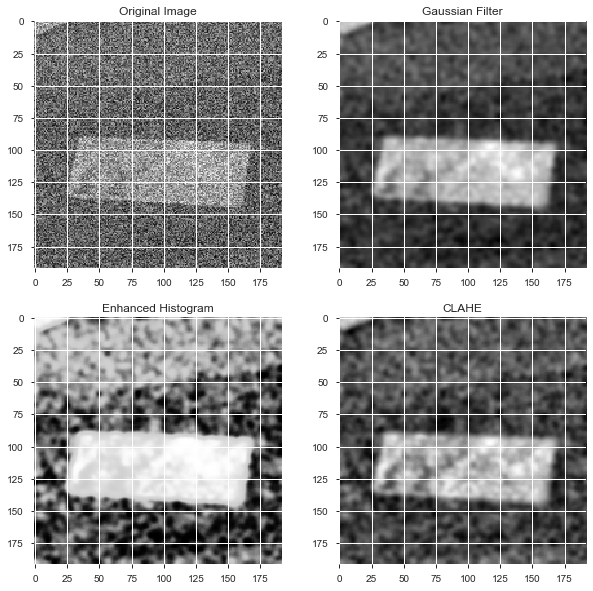

In [121]:
from matplotlib import pyplot as plt
import cv2

infile_path = './data/gray_train_val_test/train/full_visibility/GICSD_10_4_133.png'
# './data/grayscale_images/partial_visibility/GICSD_11_3_93.png'
outfile_path = 'test.png'
#convert RGB img to numpy.array
img = cv2.imread(infile_path) #'./data/images/GICSD_1_0_3.png'
# as cv2 is BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#convert to 1x channel image (greyscale) np.array
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#noise reduction
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
plt.gray()
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)  # left side

ax2 = fig.add_subplot(222)  # right side
ax3 = fig.add_subplot(223)  # right side
ax4 = fig.add_subplot(224)  # right side
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 1) Apply Gaussian filter to smooth the image in order to remove the noise
blurred = gaussian_filter(img_gray, sigma=2)
# 2) normalise brightness, increase contrast
contrast1 = cv2.equalizeHist(blurred)
# create a CLAHE object (contrast limiting & adaptive histogram equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
contrast2 = clahe.apply(blurred)

ax1.imshow(img_gray)
ax2.imshow(blurred)
ax3.imshow(contrast1)
ax4.imshow(contrast2)
ax1.title.set_text('Original Image')
ax2.title.set_text('Gaussian Filter')
ax3.title.set_text('Enhanced Histogram')
ax4.title.set_text('CLAHE')

plt.show()

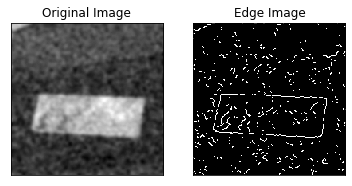

In [5]:
"""
The Process of Canny edge detection algorithm can be broken down to 5 different steps:
-Apply Gaussian filter to smooth the image in order to remove the noise
-Find the intensity gradients of the image
-Apply non-maximum suppression to get rid of spurious response to edge detection
-Apply double threshold to determine potential edges
-Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak 
and not connected to strong edges.
"""

edges = cv2.Canny(blurred,35, 35,apertureSize = 3)
plt.subplot(121),plt.imshow(blurred,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

Didn't use full canny edge detection in the end due to low quality images returning a lot of noise.

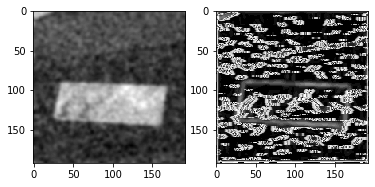

In [9]:
from scipy.ndimage import gaussian_gradient_magnitude
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
result = gaussian_gradient_magnitude(blurred, mode='constant', sigma=2,cval=20)
ax1.imshow(blurred)
ax2.imshow(result)
plt.show()

In [303]:
def filter_image(infile_path, equalize_hist=False):
    # read image as 1x channel img
    img = cv2.imread(infile_path, cv2.IMREAD_GRAYSCALE)
    # 1) Apply Gaussian filter to smooth the image in order to remove the noise
    new_img = gaussian_filter(img, sigma=2)
    if equalize_hist == True: #optional
        # create a CLAHE object (contrast limiting & adaptive histogram equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        new_img = clahe.apply(new_img)
    return new_img

In [304]:
def filter_images_in_dir(in_dir, out_dir):
    """apply image filters to all png files in a directory,
    save altered images to new directory"""
    import cv2, os
    # list files
    filepaths = get_files(in_dir,'png')
    for img in filepaths:
        img_filtered = filter_image(img,equalize_hist=False)
        #maintain same filename 
        outfile_path = out_dir + '/' + os.path.basename(img)
        cv2.imwrite(outfile_path, img_filtered)

Decision to generate a gaussian blurred dataset ad gaussian blurred + CLAHE dataset to see if these training images produce a better model.

## Gaussian blur images

In [299]:
in_directory = './data/gray_train_val_test/'
in_dirs = list_lowest_dirs(in_directory)
in_dirs

['./data/gray_train_val_test/test/partial_visibility',
 './data/gray_train_val_test/test/full_visibility',
 './data/gray_train_val_test/test/no_visibility',
 './data/gray_train_val_test/train/partial_visibility',
 './data/gray_train_val_test/train/full_visibility',
 './data/gray_train_val_test/train/no_visibility',
 './data/gray_train_val_test/val/partial_visibility',
 './data/gray_train_val_test/val/full_visibility',
 './data/gray_train_val_test/val/no_visibility']

In [300]:
out_directory = './data/gauss_gray_trainvaltest/'
out_dirs = list_lowest_dirs(out_directory)
out_dirs

['./data/gauss_gray_trainvaltest/test/partial_visibility',
 './data/gauss_gray_trainvaltest/test/full_visibility',
 './data/gauss_gray_trainvaltest/test/no_visibility',
 './data/gauss_gray_trainvaltest/train/partial_visibility',
 './data/gauss_gray_trainvaltest/train/full_visibility',
 './data/gauss_gray_trainvaltest/train/no_visibility',
 './data/gauss_gray_trainvaltest/validation/partial_visibility',
 './data/gauss_gray_trainvaltest/validation/full_visibility',
 './data/gauss_gray_trainvaltest/validation/no_visibility']

In [301]:
# gaussian filter images, save in new directory
for in_dir, out_dir in zip(in_dirs, out_dirs):
    filter_images_in_dir(in_dir, out_dir)

In [42]:
# generate labels.csv for AutoML
format_training_data_csv('./data/gauss_gray_trainvaltest/', 'gs://gauss-grayscale-ids/')

    SET                                            GCS_URI               LABEL
0  TEST  gs://gauss-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
1  TEST  gs://gauss-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
2  TEST  gs://gauss-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
3  TEST  gs://gauss-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY
4  TEST  gs://gauss-grayscale-ids/test/partial_visibili...  PARTIAL_VISIBILITY


## Gaussian Blur & CLAHE

In [302]:
out_directory = './data/clahe_gray_trainvaltest/'
out_dirs = list_lowest_dirs(out_directory)
out_dirs

['./data/clahe_gray_trainvaltest/test/partial_visibility',
 './data/clahe_gray_trainvaltest/test/full_visibility',
 './data/clahe_gray_trainvaltest/test/no_visibility',
 './data/clahe_gray_trainvaltest/train/partial_visibility',
 './data/clahe_gray_trainvaltest/train/full_visibility',
 './data/clahe_gray_trainvaltest/train/no_visibility',
 './data/clahe_gray_trainvaltest/validation/partial_visibility',
 './data/clahe_gray_trainvaltest/validation/full_visibility',
 './data/clahe_gray_trainvaltest/validation/no_visibility']

In [305]:
def filter_images_in_dir(in_dir, out_dir):
    import cv2, os
    # list files
    filepaths = get_files(in_dir,'png')
    for img in filepaths:
        img_filtered = filter_image(img,equalize_hist=True) #set to true
        #maintain same filename 
        outfile_path = out_dir + '/' + os.path.basename(img)
        cv2.imwrite(outfile_path, img_filtered)

In [306]:
# gaussian filter and CLAHE images, save in new directory
for in_dir, out_dir in zip(in_dirs, out_dirs):
    filter_images_in_dir(in_dir, out_dir)

In [43]:
# generate labels.csv for AutoML model creation
format_training_data_csv('./data/clahe_gray_trainvaltest/', 'gs://clahe-gauss-gray-ids/')

    SET                                            GCS_URI               LABEL
0  TEST  gs://clahe-gauss-gray-ids/test/partial_visibil...  PARTIAL_VISIBILITY
1  TEST  gs://clahe-gauss-gray-ids/test/partial_visibil...  PARTIAL_VISIBILITY
2  TEST  gs://clahe-gauss-gray-ids/test/partial_visibil...  PARTIAL_VISIBILITY
3  TEST  gs://clahe-gauss-gray-ids/test/partial_visibil...  PARTIAL_VISIBILITY
4  TEST  gs://clahe-gauss-gray-ids/test/partial_visibil...  PARTIAL_VISIBILITY


# Model Evaluation

Created 3 different AutoML Models trained on 3 different datasets.
1. Grayscale Images 
2. Grayscale + Gaussian Filtered Images
3. Grayscale + Gaussian Filtered + CLAHE (Contrast Limited Adaptive Histogram Equalization) Images

**All 3 dasets included augmented data for `PARTIAL_VISIBILITY` and `NO_VISIBILITY` labels.*

In [6]:
# AUtoML predict and view only
# %env GOOGLE_APPLICATION_CREDENTIALS=[PATH]

In [73]:
project_id = 'xxxxxxxxx-ids'
compute_region = 'us-central1'

In [111]:
# Edited from https://github.com/GoogleCloudPlatform/python-docs-samples/blob/master/vision/automl/automl_vision_model.py
def get_model_evaluation(project_id, compute_region, model_id, model_evaluation_id):
    """Get model evaluation."""
    from google.cloud import automl_v1beta1 as automl
    
    client = automl.AutoMlClient()
    # Get the full path of the model evaluation.
    model_evaluation_full_id = client.model_evaluation_path(
        project_id, compute_region, model_id, model_evaluation_id
    )
    # Get complete detail of the model evaluation.
    response = client.get_model_evaluation(model_evaluation_full_id)
    print(response)


def display_evaluation(project_id, compute_region, model_id, filter_):
    """Display evaluation."""
    from google.cloud import automl_v1beta1 as automl
    
    client = automl.AutoMlClient()
    # Get the full path of the model.
    model_full_id = client.model_path(project_id, compute_region, model_id)
    # List all the model evaluations in the model by applying filter.
    response = client.list_model_evaluations(model_full_id, filter_)
    # Iterate through the results.
    for element in response:
        # There is evaluation for each class in a model and for overall model.
        # Get only the evaluation of overall model.
        if not element.annotation_spec_id:
            model_evaluation_id = element.name.split("/")[-1]
    # Resource name for the model evaluation.
    model_evaluation_full_id = client.model_evaluation_path(
        project_id, compute_region, model_id, model_evaluation_id
    )
    # Get a model evaluation.
    model_evaluation = client.get_model_evaluation(model_evaluation_full_id)
    class_metrics = model_evaluation.classification_evaluation_metrics
    confidence_metrics_entries = class_metrics.confidence_metrics_entry

    # Showing model score based on threshold of 0.5
    for confidence_metrics_entry in confidence_metrics_entries:
        if confidence_metrics_entry.confidence_threshold == 0.5:
            print("Precision and recall are based on a score threshold of 0.5")
            print(
                "Model Precision: {}%".format(
                    round(confidence_metrics_entry.precision * 100, 2)
                )
            )
            print(
                "Model Recall: {}%".format(
                    round(confidence_metrics_entry.recall * 100, 2)
                )
            )
    print(
        "\n Average Precision (AuPRC): {}%".format(
            round(class_metrics.au_prc * 100, 2)
        )
    )

## 1) Grayscale Images

In [97]:
model_id = 'ICN7339007018939711488'
display_evaluation(project_id, compute_region, model_id, filter_=None)

Precision and recall are based on a score threshold of 0.5
Model Precision: 80.67%
Model Recall: 80.0%

 Average Precision (AuPRC): 83.23%


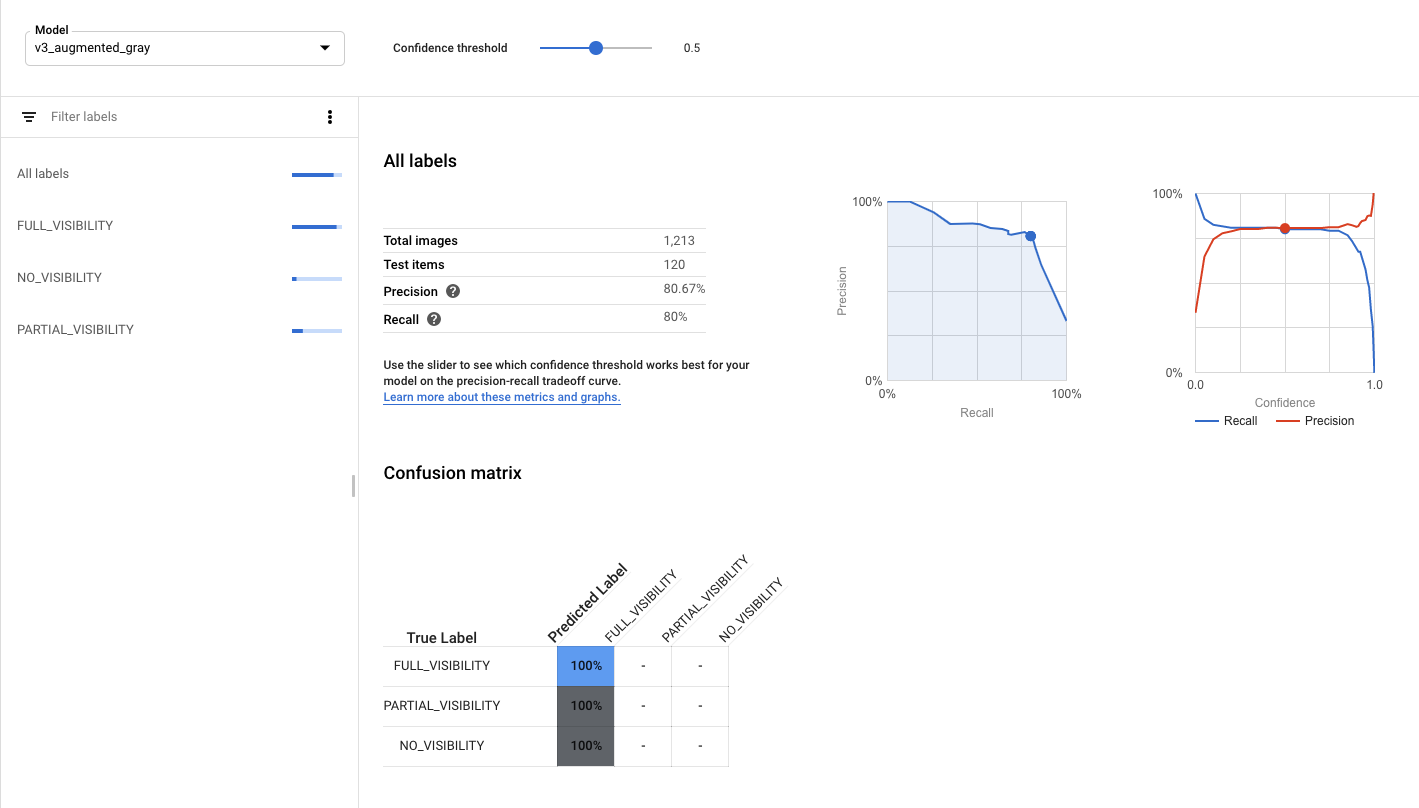

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename ='./misc/model_eval_screenshots/gray.png', width=1000, height=800)

## 2) Grayscale + Gaussian Filtered Images

In [98]:
model_id = 'ICN197423909836947456'
display_evaluation(project_id, compute_region, model_id, filter_=None)

Precision and recall are based on a score threshold of 0.5
Model Precision: 86.61%
Model Recall: 80.83%

 Average Precision (AuPRC): 89.39%


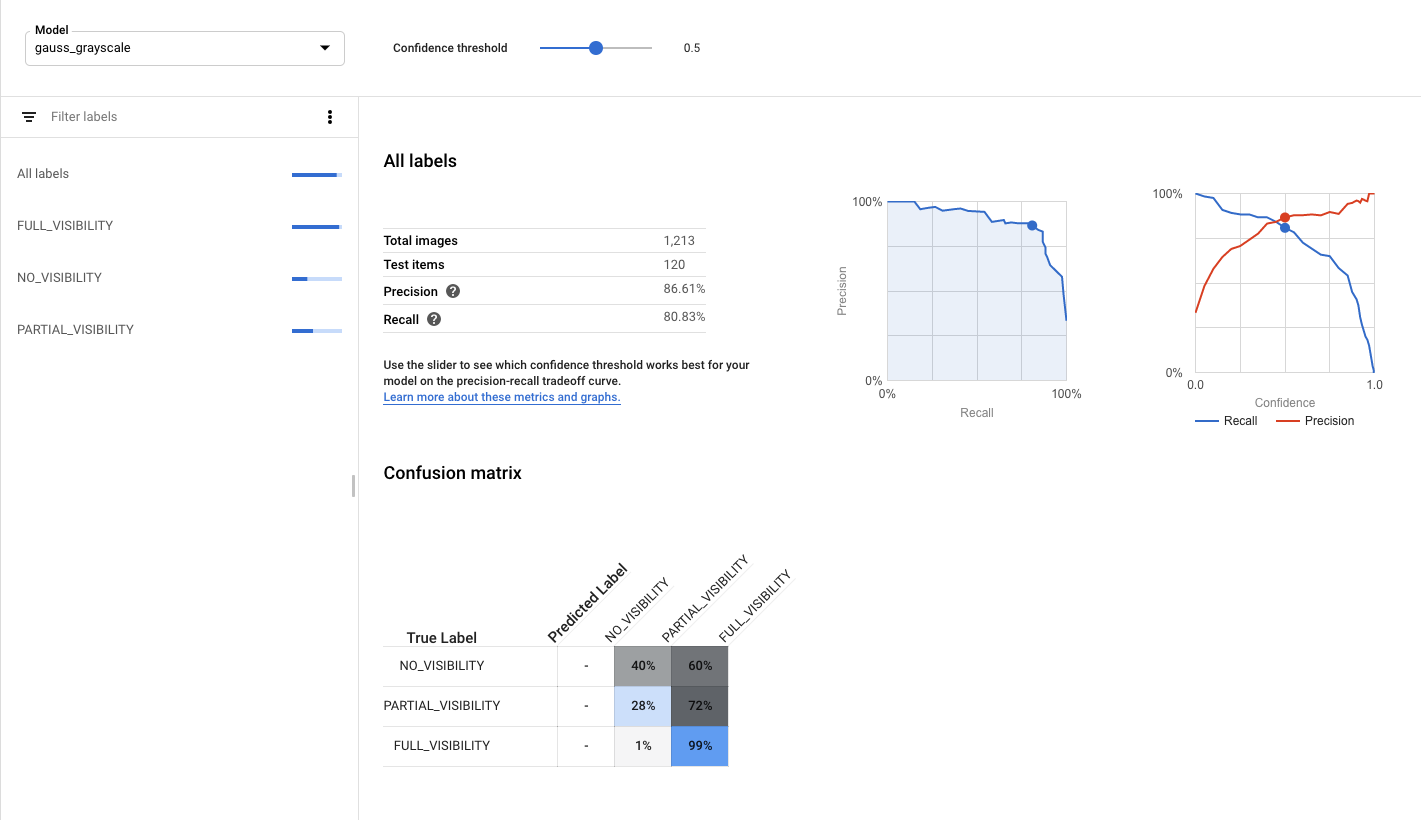

In [109]:
Image(filename ='./misc//model_eval_screenshots/gauss_gray.png', width=1000, height=800)

## 3) Grayscale + Gaussian Filtered + CLAHE

In [99]:
model_id = 'ICN1302494668402982912'
display_evaluation(project_id, compute_region, model_id, filter_=None)

Precision and recall are based on a score threshold of 0.5
Model Precision: 84.75%
Model Recall: 83.33%

 Average Precision (AuPRC): 88.36%


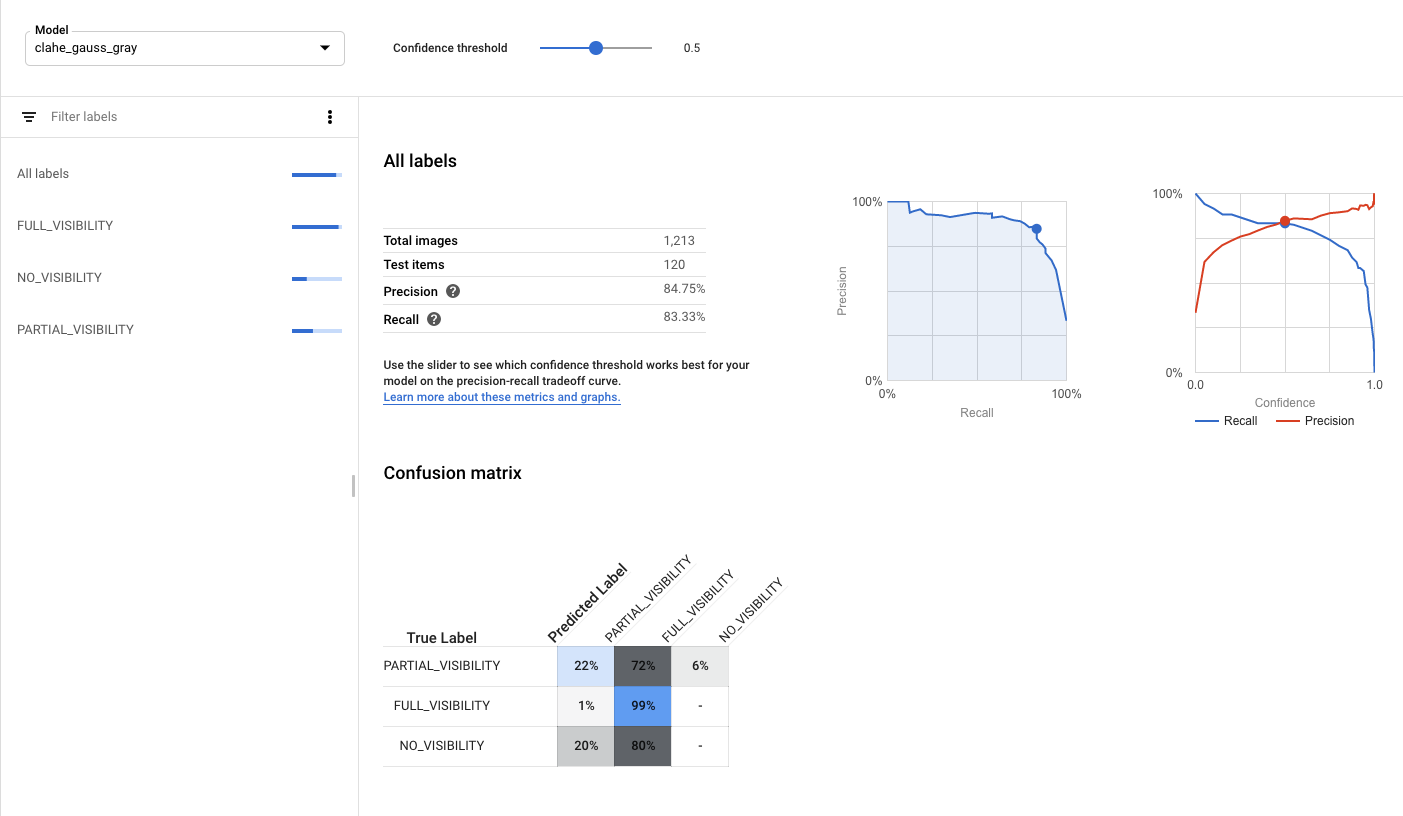

In [110]:
Image(filename ='./misc/model_eval_screenshots/clahe_gauss_gray.png', width=1000, height=800)

# Conclusion 

I decided to productionise, model #2 trained on the Grayscale + Gaussian Filtered Images dataset, due to its highest average precision. 

The confusion matrix for model 2, (representing the percent of times each label was predicted for each label in the training set during evaluation) also showed highest predictability for `PARTIAL_VISIBILITY` at 28% compared to other 2 models - although this still isn't great.

Predictability for the images with `FULL_VISIBILITY` ID cards was a high 99 to 100% in all 3 models, as anticipated, due to larger training dataset for that class, without data augmentation.